# Quantum Monte Carlo (QMC)
## a basic demonstration

In [1]:
import autograd.numpy as np #tricky!
import autograd
from numpy import random as rdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

## Monte Carlo sampling and integration

The most common use for Monte Carlo methods in science is the is the calculation of expectation values of high-dimensional functions $f$ over an analytically specified probability distribution. The basic process is as follows: 'sample' the distribution (i.e. create a series of points $\bf{X}_i$ with a density proportional to the probability density of the distribution), then take the average of $f(\bf{X}_i)$.

### Metropolis MCMC sampling

The most common sampling method is the 'Metropolis Markov Chain Monte Carlo' method (often called Metropolis MCMC), originally outlined by [Nicholas Metropolis et al. in 1953 for chemistry applications](https://en.wikipedia.org/wiki/Equation_of_State_Calculations_by_Fast_Computing_Machines). Below is a description and implementation of this algorithm to sample a probability distribution $P(\bf{X})$.

1. Begin with an initial point chosen at random $\bf{X_0}$, then make a random move from this point to a new point $\bf{X_1}$ according to a Gaussian distribution centered at $\bf{X_0}$.
2. Calculate the 'Metropolis acceptance probability': $$W(X_1|X_0) = \min \left(\frac{P(\bf{X_1})}{P(\bf{X_0})}, 1 \right)$$
3. With probability $W$, accept the move. If the move is not accepted, try a different move.
4. Repeat the process, now starting at $\bf{X_1}$ and moving to $\bf{X_2}$...
5. For the first few hundred moves, the 'equilibration' phase, do not save the points. After a while, the points should begin to stay within the bounds of the probability distribution $P(\bf{X})$, and you can save the points.

Below is an animation of the process: starting from the first point, a move is suggested and accepted, then another is suggested and rejected, before a final is suggested and accepted.

![MCMC algorithm animation](<MCMC animation.gif>)

When calculating expectation value $E$ of a function $f$, the following weighted average gives more accurate results than simply evaluating the function once: $$E(f, P) \approx \frac{1}{M}\sum_{n=1}^M \frac{1}{2} \left(f(\bf{X_i})W(\bf{X_i}|\bf{X_{i-1}})+(1-W(\bf{X_i}|\bf{X_{i-1}}))f(\bf{X_{i-1}})\right)$$

Where $M$ is the number of points sampled.

Below these algorithms are implemented in 3 functions: 

1. _move_ facilitates moves from $\bf{X_{i-1}}$ to $\bf{X_{i-1}}$
2. _sample_ organizes the sampling procedure
3. _expectation_ takes the expectation value

In [2]:
#Defining the 'move' function
def move(A, P, n, i=0, max_recursion=10, stdv=2, base_dim=3):
    """
    Facilitates move from A to B, accepts and returns B
    OR rejects B and recursively starts over at A.
    This algorithm tends to work best moving only one 'particle'
    at a time.
    
    Args: 
        A: starting point
        P: probability distribution
        n: particle being moved.
        i, max_recursion: recursion trackers
        stdv: the standard deviation of each step size
        base_dim: number of dimensions of real space
                  in which the problem takes place
    
    """
    B = np.zeros(A.shape) #setting B to A raises issues
    B += A
    B[n] += stdv*stats.norm.rvs(size=(base_dim)) #random step
    acc = rdm.rand() #threshold required to accept sample
    W = min(1, (P(B)/P(A))) #Metropolis acceptance probability
    if (acc <= W or i>= max_recursion):
        return B, W
    else:
        return move(A, P, n, i=i+1, base_dim=base_dim)

In [3]:
#Defining 'sample' function

def sample(P, M, N, window=2, equilib_time=1000, dim=3):
    """
    This function samples a probability distribution using Metropolis
    Markov Chain Monte Carlo. 
    
    Args:
        P: probability distribution
        M: number of samples
        N: number of particles
        window: dimension of box in which the initial point is generated
        
    """
    
    #generate initial sample
    samples = window*(rdm.rand(1, N, dim)-0.5)
    
    #Equilibration phase
    for m in range(equilib_time):
        for n in range(N):
            samples[0], W = move(samples[0], P, n, base_dim=dim)
            
    #Begin accumulating
    for m in range(1, M):
        #starts next sample at previous sample's location
        samples = np.append(samples, [samples[m-1]], axis=0)
        for n in range(N):
            #moves it 1 particle at a time
            samples[m], W = move(samples[m], P, n, base_dim=dim) 
            
    return samples           

In [4]:
def expectation(f, P, M, N, window=2, equilib_time=1000, dim=3):
    """
    This function is the same as the previous but also evaluates an integral
    using the average formula described above. 
    
    Args:
        f: function of interest
        P: probability distribution
        M: number of samples
        N: number of particles
        window: dimension of box in which the initial point is generated
        
    """
    #generate initial sample
    samples = window*(rdm.rand(1, N, dim)-0.5)
    
    #Equilibration phase
    for m in range(equilib_time):
        for n in range(N):
            samples[0], W = move(samples[0], P, n)
            
    #Begin accumulating
    I = 0 #integral to be added to
    
    for m in range(1, int(M/N)):
        #note -- this time it's M/N to maintain M evaluations of f
        #starts next sample at previous sample's location
        samples = np.append(samples, [samples[m-1]], axis=0)
        for n in range(N):
            #saves previous move
            prev_move = samples[m]
            
            #moves it 1 particle at a time
            samples[m], W = move(samples[m], P, n)
            
            #Accumulates contribution to integral
            I += 1/(int(M/N)*N) * (W*f(samples[m]) + (1-W)*f(prev_move))
            
    return samples, I

### Test of Metropolis MCMC algorithms

These three algorithms are tested on the energy of a 2p-orbital of a hydrogen atom: $$P(r, \theta) = \Psi^2 = \left(\exp\left(-\frac{1}{a_0} \frac{r}{2}\right) r \cos(\theta) \right)^2$$

$$\left< H\right> = E\left(\frac{1}{\Psi}\left(-\frac{\hbar^2}{2m}\nabla^2 + \frac{ke^2}{r} \right)\Psi, P\right)$$
In spherical coordinates, where $a_0$ is the Bhor radius, $e$ is the electron charge, $m$ is the electron mass and $k$ is the Coulomb constant (all 1 in Hartree units). The expression $$\frac{1}{\Psi}\left(-\frac{\hbar^2}{2m}\nabla^2 + \frac{ke^2}{r} \right)\Psi$$ is very common in QMC methods, and is called the 'local energy' $E_l$.

In [5]:
#Defining some constants, as labeled above
a0 = 1
hbar = 1
e = 1
m = 1
k = 1

#Defining 2p orbital wave function
def p(X):
    """takes vector of form [[x, y, z]]"""
    #defining necessary spherical coordinates
    r = np.sqrt(np.sum((X[0])**2))
    theta = 0
    if (r > 0.01): #to catch 0 division
        theta = np.arccos((X[0,0])/r)
        
    return (np.e**(-1/a0 * r/2))*r*np.cos(theta)

#Defining 2p modulus squared as the probability distribution P
def P(X):
    return p(X)**2  

Below, I've also defined the functions necessary for calculating $E_l$. These will be relevant throughout this introduction.

In [6]:
#Defining Kinetic Energy
def T(R, psi):
    grad_psi = autograd.grad(psi)
    
    #What follows is made difficult since autograd has no Laplacian
    def grad1(R, n, i):
        return grad_psi(R)[n, i]
    
    laplace = 0
    if (R.size > 1):
        for n in range(1):
            for i in range(3):
                grad2 = autograd.grad(grad1)
                laplace += np.sum(grad2(R, n, i)[n, i])
    else:
        doublegrad_psi = autograd.grad(grad_psi)
        laplace += np.sum(doublegrad_psi(R))
    
    return -np.sum(laplace * m / (2*hbar**2))

#Defining Coulomb potential
def V_c(R):
    r = np.sqrt(np.sum(R[0]**2))
    
    return -k*e**2/(r)

#Defining local energy.
def E_local(R, psi, V):
    #We have to do a little cheat to prevent infinities--
    if (np.sqrt(np.sum(R[0]**2)) > 0.01):
        return T(R, psi)/(psi(R)) + V(R)
    else:
        return 0

Finally, we're ready to test the Metropolis MCMC algorithm (this may take a moment to run):

In [7]:
#A required local energy wrapper for 2p orbital
def p_E_local(R):
    return E_local(R, p, V_c)

p_samples, p_energy = expectation(p_E_local, P, 5000, 1)

print(f'Calculated energy in Hartree units: {p_energy} Hartrees')
print(f'The actual energy of a p2 orbital in a Hydrogen atom is -0.12495 Hartrees')

Calculated energy in Hartree units: -0.12497499999999032 Hartrees
The actual energy of a p2 orbital in a Hydrogen atom is -0.12495 Hartrees


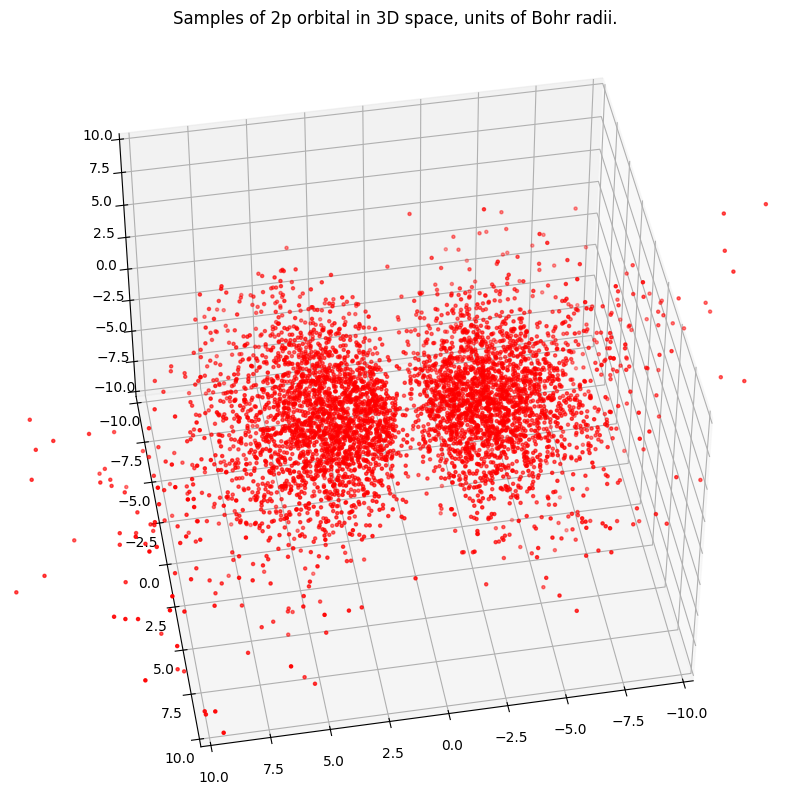

In [8]:
#Create plot of sample distribution
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.view_init(45,80)

window = 10
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Samples of 2p orbital in 3D space, units of Bohr radii.')

ax.scatter(p_samples[:, 0, 0], p_samples[:, 0, 1], p_samples[:, 0, 2], marker = ".", color = 'r')

Which is exactly what the 2p orbital should look like!

## Variational Monte Carlo (VMC)

We finally arrive at Quantum Monte Carlo (QMC), with the goal (insofar as we are concerned) of finding ground state wave energies/wave functions. The key component of VMC is a 'variational wave function'---an analytic guess for the wave function function that depends on a one or more unknown parameters. The VMC algorithm changes these parameters until the variational wave function looks approximately like the ground state wave function. Generally, this means doing gradient descent to minimize either the expectation value of the energy (for obvious reasons) or the variance of the energy (as energy eigenstates have constant energies). 

The Monte Carlo part comes in when evaluating the expectation value of the energy or variance: $$\left<H\right> = \int dR \psi^\dagger E_0 \psi = \int dR \psi^\dagger H \psi$$
Meaning: $$E_0 = \frac{1}{\int dR \psi^\dagger \psi} \int dR \psi^\dagger H \psi = \frac{1}{\int dR \psi^\dagger \psi} \int dR \psi^\dagger \psi \frac{ H \psi}{\psi}$$

This part is basically a probability distribution: $$\frac{\psi^\dagger \psi}{\int dR \psi^\dagger \psi}$$ 

So we can sample it and use MCMC to calculate the expectation value of: $$\frac{ H \psi}{\psi}$$ which is just the local energy from before! One note -- none of these wave functions need to be normalized, as we divide them out in the end anyway. We'll start by defining some helpful functions.

In [9]:
def evaluate(a, psi_var, V, M=500):
    """
    This evaluates the energy and variance of a wave function
    psi_var(X, a) with variational parameter 'a'
    
    """
    
    #some aux functions of use:
    def psi_wrapper(X):
        #turns psi dependent on a to a non-a-dependent function
        return psi_var(X, a)
    
    def P(X):
        #gives a probability distribution from |psi|^2
        return (psi_var(X, a))**2
    
    samples = sample(P, M, 1)
    
    I = 0 #integral for expectation value of E
    for x in samples:
        I += 1/M * (E_local(x, psi_wrapper, V))
    
    J=0 #for expectation value of variance
    for x in samples:
        J += 1/M * (E_local(x, psi_wrapper, V)-I)**2
    
    return I, np.sqrt(J)

We'll also be solving a very simple problem -- the ground energy of a hydrogen atom. We'll be using a variational wave function with one parameter: $$\Psi(a, r) \propto \exp(-r) + a\psi_{2p}$$
First, let's look at the landscape of this wave function---how do $\left<H\right>$ and the standard deviation $\sigma$ depend on $a$?

In [10]:
#A superposition of 1s and 2p eigenstates
def psi(X, a):
    r = np.sqrt(np.sum(X[0]**2))
    return np.e**(-r) + a * p(X) #p is the 2p wave function from before


In [11]:
#Calculating the full landscape:

a_s = np.linspace(-0.5, 0.5, 30)
E_s = np.zeros(30)
errs= np.zeros(30)

for i in range(20):
    E_s[i], errs[i] = evaluate(a_s[i], psi, V_c, M=500)
    print(f'{E_s[i]}, {errs[i]}')
    


-0.12280986344481432, 0.10195363649593879
-0.14397629901308093, 0.12114577318161279
-0.13855187668632016, 0.1467120133876343
-0.16906086162408424, 0.11490721425903745
-0.17138649458297, 0.1629886691639247
-0.14337881577009923, 0.11295658008613046
-0.16846086656899106, 0.15497599971748946
-0.16172297266945693, 0.3937058004118357
-0.18518728244775734, 0.15829825932968852
-0.2193608172136556, 0.20638816592315143
-0.21068080284897778, 1.407889703684061
-0.31060013546662485, 0.32437417810519675
-0.29977126474822624, 0.6525568458613006
-0.34955757949473387, 0.28878833418307187
-0.47030039792275513, 0.14642243811664726
-0.4913944926450822, 0.07056516005523791
-0.38759462515654625, 0.6786623445295894
-0.24961306722784632, 0.5101370716693775
-0.3306969899989783, 1.9537615998739082
-0.23068972409851365, 0.19550696285615815


Text(0.5, 1.0, "Error landscape -- how does the error depend on 'a'? ")

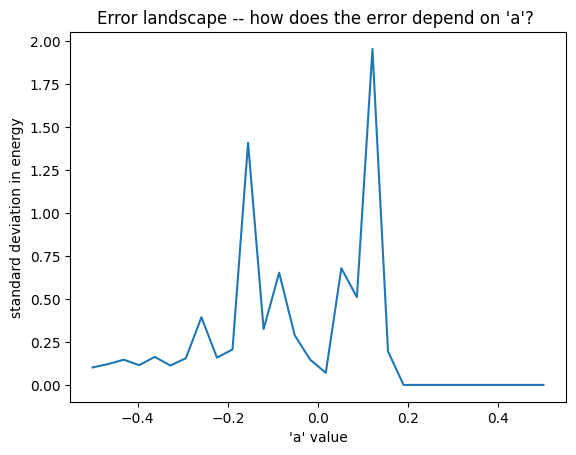

In [12]:
plt.plot(a_s, errs)
plt.xlabel('\'a\' value')
plt.ylabel('standard deviation in energy')
plt.title('Error landscape -- how does the error depend on \'a\'? ')

Text(0.5, 1.0, "Energy landscape -- how does the energy depend on 'a'? ")

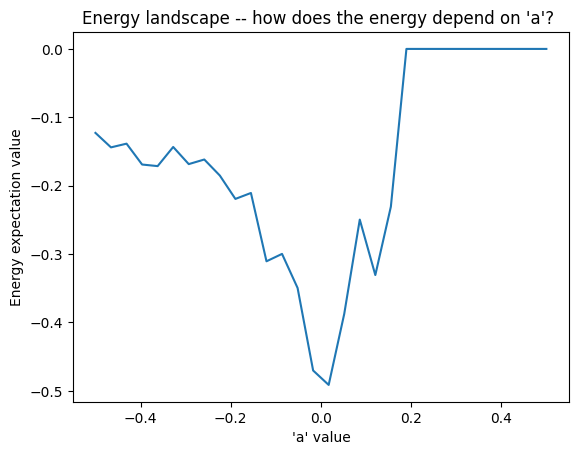

In [13]:
plt.plot(a_s, E_s)
plt.xlabel('\'a\' value')
plt.ylabel('Energy expectation value')
plt.title('Energy landscape -- how does the energy depend on \'a\'? ')

So, for the purposes of gradient descent, it looks like directly minimizing the energy may be the best strategy. The error landscape is simply too oscillatory and noisy. 

The following is a simple optimization strategy (This also takes a good amount of time, I apologize). 

In [14]:
t = 0.05 #parameterizes size of each step


a_s = rdm.rand(30)-0.5
E_s = np.zeros(30)
grads= rdm.rand(30)-0.5
E_s[0], err = evaluate(a_s[0], psi, V_c, M=500)
print(f'{a_s[0]}: {E_s[0]}, {grads[0]}')

for i in range(1, 30):
    a_s[i] = a_s[i-1]-t*grads[i-1]
    E_s[i], err = evaluate(a_s[i], psi, V_c, M=500)
    grads[i] = (E_s[i]-E_s[i-1])/(a_s[i]-a_s[i-1])
    
    #prevents extreme gradients around a=0 cusp
    grads[i] /= abs(grads[i])
    print(f'{a_s[i]}: {E_s[i]}, {grads[i]}')
    



-0.29412758529566263: -0.18557602145496588, -0.20895106057913737
-0.28368003226670574: -0.18420505949034954, 1.0
-0.33368003226670573: -0.16822524786998608, -1.0
-0.28368003226670574: -0.18000556857836025, -1.0
-0.23368003226670575: -0.1853497574072342, -1.0
-0.18368003226670576: -0.206923703288932, -1.0
-0.13368003226670577: -0.2751010900854831, -1.0
-0.08368003226670577: -0.3411041108169722, -1.0
-0.03368003226670577: -0.3813755393396281, -1.0
0.016319967733294236: -0.4452075899431075, -1.0
0.06631996773329424: -0.34609770691540304, 1.0
0.016319967733294236: -0.4731261304460092, 1.0
-0.03368003226670577: -0.4291668555101087, -1.0
0.016319967733294236: -0.48285276868654564, -1.0
0.06631996773329424: -0.27502516875730976, 1.0
0.016319967733294236: -0.4862283973956112, 1.0
-0.03368003226670577: -0.35740791596898763, -1.0
0.016319967733294236: -0.44906876678245683, -1.0
0.06631996773329424: -0.3706765823625662, 1.0
0.016319967733294236: -0.47070598488536086, 1.0
-0.03368003226670577: -0.

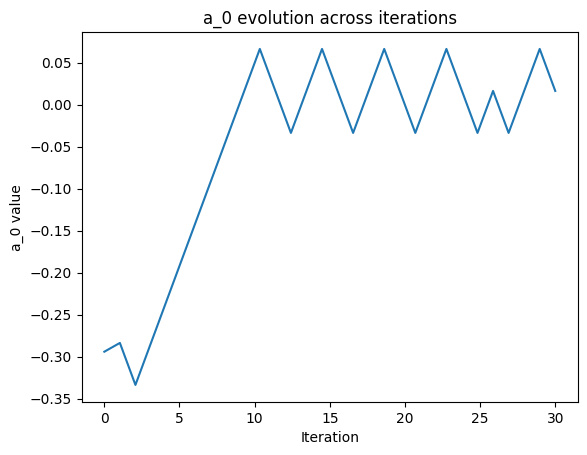

Text(0.5, 1.0, 'Energy across iterations')

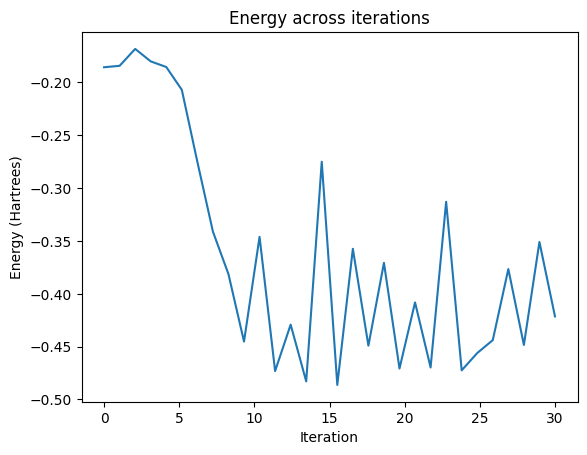

In [15]:
i = np.linspace(0, 30, 30)

plt.plot(i, a_s)
plt.xlabel('Iteration')
plt.ylabel('a_0 value')
plt.title('a_0 evolution across iterations')
plt.pause(0.1)
plt.plot(i, E_s)
plt.xlabel('Iteration')
plt.ylabel('Energy (Hartrees)')
plt.title('Energy across iterations')


As we can see, even this proof of concept method can identify an accurate value of $a_0 \approx 0$ and $E_0 \approx -0.5$ Hartrees.